## BaseLine_1
##### This baseline is the basic resnet50 model fine-tuned for group activity recognition in a single frame
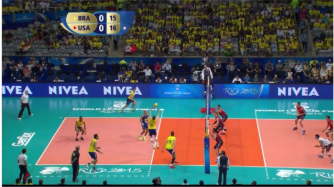

## Cloning the Repository

In [1]:
!rm -rf /kaggle/working/github
!git clone https://github.com/shehab-ashraf/Group-Activity-Recognition.git /kaggle/working/github
import sys
sys.path.append('/kaggle/working/github/')

Cloning into '/kaggle/working/github'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 66 (delta 16), reused 52 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (66/66), 31.34 KiB | 6.27 MiB/s, done.
Resolving deltas: 100% (16/16), done.


## Installing Required Dependencies

In [2]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.9 MB/s eta 0:00:00a 0:00:01


## Importing Necessary Libraries

In [69]:
import torch
from functools import partial
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
import torch.nn.functional as F
import torch.optim as optim
from data_utils.dataloader import *
from data_utils.dataset import *
from Learner.learn import *
from models.BaseLine_1.model import *
from helper_utils.helper import *

## Creating DataLoaders
 we create DataLoaders for training and validation

In [5]:
classes_names = ['l-pass', 'r-pass', 'l_set', 'r_set' ,'l-spike', 'r_spike', 'l_winpoint', 'r_winpoint']
classes_labels = {class_name:label for label, class_name in enumerate(classes_names)}

videos_path = '/kaggle/input/group-activity-recognition-volleyball/videos'
annot_path  = '/kaggle/input/group-activity-recognition-volleyball/annot_all.pkl'

train_videos = [1, 3, 6, 7, 10, 13, 15, 16, 18, 22, 23, 31, 32, 36, 38, 39, 40, 41, 42, 48, 50, 52, 53, 54]
valid_videos = [0, 2, 8, 12, 17, 19, 24, 26, 27, 28, 30, 33, 46, 49, 51]


dls = create_dataloader(
    videos_path=videos_path,
    annot_path=annot_path,
    labels=classes_labels,
    train_split=train_videos,
    valid_split=valid_videos,
    mode="image_level",
    batch_size=64,
    num_workers=4
)

## Check DataSet
see if data is prepared as we want

In [6]:
len(dls.train), len(dls.valid)

(303, 189)

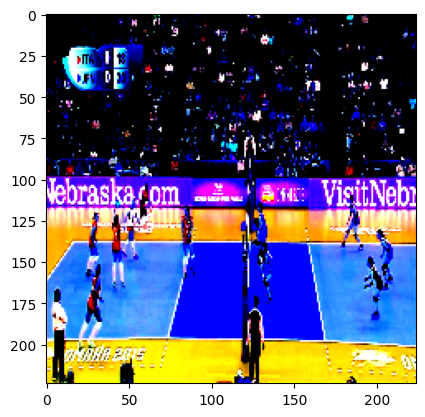

In [68]:
it = iter(dls.train)
im = next(it)[0][0]
show_image(im)

## Setting Up Training Callbacks
we define training callbacks including:<br>
MetricsCB: For tracking accuracy<br>
TrainCB: General training utilities<br>
ProgressCB: Visualizing training progress<br>
DeviceCB: Ensuring correct device allocation<br>
we then initialize the Learner class and try to find an good learning-rate.

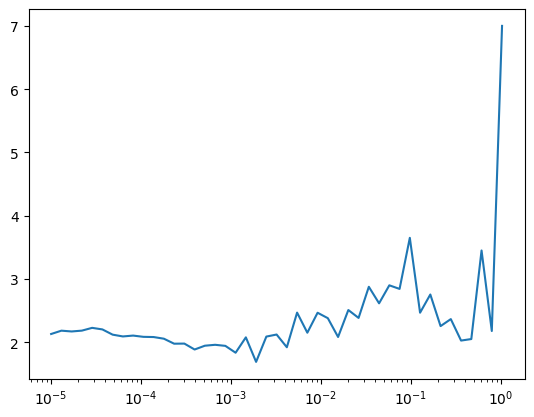

In [45]:
Group_Activity_Classifier = GroupActivityClassifier(num_classes=len(classes_names))
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs=[metrics, TrainCB(), ProgressCB(plot=True), DeviceCB()] 
Group_Activity_Recognition_Learner = Learner(Group_Activity_Classifier, dls, loss_func=F.cross_entropy, cbs=cbs, opt_func=optim.AdamW)
Group_Activity_Recognition_Learner.lr_find()

## Training the Model
Finally, we train the model using the AdamW optimizer and OneCycleLR scheduler for 10 epochs.

In [53]:
lr,epochs = 6e-4,10
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
Group_Activity_Classifier = GroupActivityClassifier(num_classes=len(classes_names))
cbs=[metrics, TrainCB(), ProgressCB(plot=False), DeviceCB(), BatchSchedCB(sched)]  
Group_Activity_Recognition_Learner = Learner(Group_Activity_Classifier, dls, loss_func=F.cross_entropy, cbs=cbs, opt_func=optim.AdamW)
Group_Activity_Recognition_Learner.fit(epochs, lr)

accuracy,loss,epoch,train
0.567,1.191,0,train
0.558,1.458,0,eval
0.827,0.494,1,train
0.590,1.544,1,eval
0.869,0.383,2,train
0.631,1.310,2,eval
0.920,0.236,3,train
0.595,1.507,3,eval
0.944,0.170,4,train
0.605,1.652,4,eval


## Testing
##### We are currently evaluating our model by performing a single iteration over the test_data.


In [47]:
test_videos = [4, 5, 9, 11, 14, 20, 21, 25, 29, 34, 35, 37, 43, 44, 45, 47]
test_dataloader = create_dataloader(
    videos_path=videos_path,
    annot_path=annot_path,
    labels=classes_labels,
    train_split=[1],
    valid_split=test_videos,
    mode="image_level",
    batch_size=64,
    num_workers=4
)

In [54]:
len(test_dataloader.train), len(test_dataloader.valid)

(23, 189)

accuracy,loss,epoch,train
0.742,1.230,0,eval


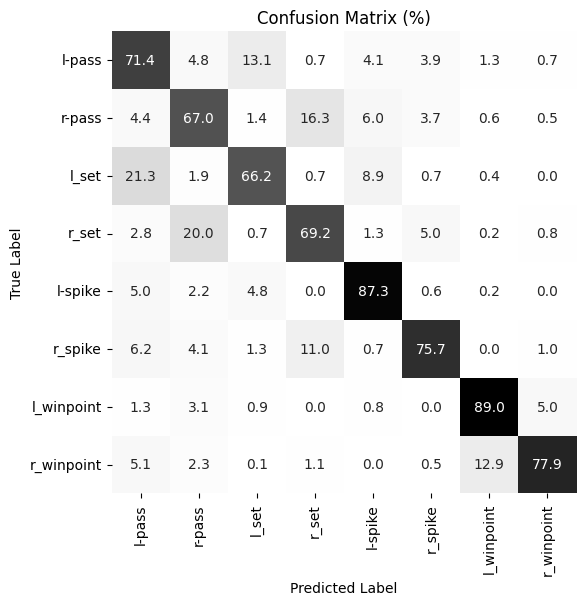

In [61]:
confusion_matrix_cb = ConfusionMatrixCB(class_names=classes_names)
cbs=[metrics, TrainCB(), ProgressCB(plot=False), DeviceCB(), confusion_matrix_cb] 
Group_Activity_Classifier.eval()
Group_Activity_Learner = Learner(model=Group_Activity_Classifier, dls=test_dataloader, loss_func=F.cross_entropy, cbs=cbs)
Group_Activity_Learner.fit(1, train=False)